In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

from datetime import datetime
import pytz

2024-02-22 20:56:09.786019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Fetch stock data and earnings dates with improved error handling
def fetch_stock_data_with_earnings(ticker, period):
    try:
        stock = yf.Ticker(ticker)

        data = stock.history(period=period)
        data.index = data.index.date

        earnings = stock.earnings_dates
        earnings.index = earnings.index.date
        
        return data, earnings
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None, None

In [3]:
# Fetch stock data
ticker = "TSLA"
period = "2y"

data, earnings = fetch_stock_data_with_earnings(ticker, period)
if data is None:
    raise ValueError("Failed to fetch stock data.")

In [4]:
# Fetch S&P 500 historical data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period=period)
sp500_data.index = sp500_data.index.date

data_sp500 = sp500_data[['Close']] 
data_sp500.columns = ['SP500_Close']    # Rename the columns for clarity and to avoid conflicts upon merging

# Merge the S&P 500 data with your existing DataFrame based on the date index
data = data.merge(data_sp500, how='left', left_index=True, right_index=True)

# Drop 'Dividends' and 'Stock Splits' and compute additional technical indicators
data = data.drop(columns=['Dividends', 'Stock Splits'])

data.tail()

,Open,High,Low,Close,Volume,SP500_Close
2024-02-15,189.160004,200.880005,188.860001,200.449997,120831800,5029.729980
2024-02-16,202.059998,203.169998,197.399994,199.949997,111173600,5005.569824
2024-02-20,196.130005,198.600006,189.130005,193.759995,104545800,4975.509766
2024-02-21,193.360001,199.440002,191.949997,194.770004,103844000,4981.799805
2024-02-22,194.000000,198.320007,191.360001,197.410004,92081183,5087.029785


In [5]:
# Function to check if the current time is within trading hours
def is_trading_hours():
    # Define US Eastern timezone
    eastern = pytz.timezone('US/Eastern')
    
    # Get current time in Eastern timezone
    now_eastern = datetime.now(eastern)
    
    # Define market open and close times (9:30 AM to 4:00 PM)
    market_open = now_eastern.replace(hour=9, minute=30, second=0, microsecond=0)
    market_close = now_eastern.replace(hour=16, minute=0, second=0, microsecond=0)
    
    # Check if current time is within trading hours
    return market_open <= now_eastern <= market_close


# Check if it's trading hours before dropping the first row
if is_trading_hours():
    print('Trading Hour.')
    data = data.drop(data.tail(1).index)    # Drop the last row from the DataFrame
else:
    print('After Hour.')

After Hour.


### SMA (Simple Moving Average)
- SMA calculates the average price of a security over a specific number of periods. It is simple because it gives equal weight to all prices in the period.
- Usage in analysis: SMA helps to smooth out price data to identify the trend direction over time. It can act as support or resistance levels; securities trading above their SMA are considered in an uptrend, whereas those below are in a downtrend.

### EMA (Exponential Moving Average)
- EMA is a type of moving average that places a greater weight and significance on the most recent data points. It is more responsive to new information compared to the SMA.
- Usage in analysis: EMA is often used to identify the direction of the trend, with prices above the EMA suggesting an uptrend and prices below indicating a downtrend. Traders might use short-term EMAs to make quick, momentum-based decisions and longer-term EMAs for overall trend direction.


### RSI (Relative Strength Index)
- RSI is a momentum oscillator that measures the speed and change of price movements on a scale of 0 to 100. It is used to identify overbought or oversold conditions in a security's price.
- Usage in analysis: Values above 70 are considered overbought (suggesting a potential sell signal), while values below 30 are considered oversold (indicating a potential buy signal). RSI can also show divergence signals, where the price trend and RSI trend move in opposite directions, suggesting a potential reversal.


### MACD (Moving Average Convergence Divergence)
- MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It consists of the MACD line (difference between two EMAs), a signal line (EMA of the MACD line), and a histogram (difference between MACD and its signal line).
- Usage in analysis: MACD is used to identify changes in the strength, direction, momentum, and duration of a trend. A bullish crossover occurs when the MACD crosses above its signal line, suggesting a buy signal, while a bearish crossover (MACD falls below the signal line) suggests a sell signal. The divergence between the MACD and price action can also indicate potential market reversals.

In [6]:
short_span, long_span = 10, 50

data['EMA_Short'] = data['Close'].ewm(span=short_span, adjust=False).mean()
data['EMA_Long'] = data['Close'].ewm(span=long_span, adjust=False).mean()

data['SMA_Short'] = data['Close'].rolling(window=short_span).mean()
data['SMA_Long'] = data['Close'].rolling(window=long_span).mean()

# RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2

In [7]:
data.tail()

,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,SMA_Short,SMA_Long,RSI,MACD
2024-02-15,189.160004,200.880005,188.860001,200.449997,120831800,5029.729980,191.211004,212.086825,188.609003,221.6408,64.214870,-8.554002
2024-02-16,202.059998,203.169998,197.399994,199.949997,111173600,5005.569824,192.799912,211.610871,189.813002,220.8654,58.458365,-7.271002
2024-02-20,196.130005,198.600006,189.130005,193.759995,104545800,4975.509766,192.974473,210.910836,191.083002,219.9532,51.843668,-6.676731
2024-02-21,193.360001,199.440002,191.949997,194.770004,103844000,4981.799805,193.300933,210.277863,192.050002,218.9958,56.731468,-6.054476
2024-02-22,194.000000,198.320007,191.360001,197.410004,92081183,5087.029785,194.048037,209.773241,193.033002,218.0672,57.549002,-5.287359


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 2022-02-23 to 2024-02-22
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         502 non-null    float64
 1   High         502 non-null    float64
 2   Low          502 non-null    float64
 3   Close        502 non-null    float64
 4   Volume       502 non-null    int64  
 5   SP500_Close  502 non-null    float64
 6   EMA_Short    502 non-null    float64
 7   EMA_Long     502 non-null    float64
 8   SMA_Short    493 non-null    float64
 9   SMA_Long     453 non-null    float64
 10  RSI          489 non-null    float64
 11  MACD         502 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 67.1+ KB


In [9]:
# Normalize features
features = data.columns.tolist()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features].bfill())

# Create a DataFrame for the scaled data, ensuring to convert features_to_scale back to a list to maintain order
scaled_data_df = pd.DataFrame(scaled_data, columns=features, index=data.index)
scaled_data_df.tail()

,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,SMA_Short,SMA_Long,RSI,MACD
2024-02-15,0.312438,0.327035,0.334007,0.337393,0.298298,0.962053,0.306138,0.365834,0.299760,0.434338,0.632327,0.316209
2024-02-16,0.359217,0.335437,0.366775,0.335566,0.261814,0.946053,0.312931,0.362881,0.304666,0.429610,0.568797,0.341013
2024-02-20,0.337713,0.318669,0.335043,0.312951,0.236777,0.926146,0.313677,0.358537,0.309842,0.424048,0.495796,0.352502
2024-02-21,0.327668,0.321751,0.345863,0.316641,0.234126,0.930311,0.315073,0.354610,0.313783,0.418211,0.549739,0.364532
2024-02-22,0.329989,0.317641,0.343599,0.326286,0.189692,1.000000,0.318267,0.351479,0.317789,0.412549,0.558761,0.379363


In [10]:
# merge earnings data
scaled_data_df = scaled_data_df.merge(earnings, how='left', left_index=True, right_index=True)

scaled_data_df = scaled_data_df.fillna(method='ffill')

# Display the merged dataframe
scaled_data_df.tail()

/var/folders/hd/pv9sg75d6b38kvxtq9c67bw40000gn/T/ipykernel_9086/3655668173.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_data_df = scaled_data_df.fillna(method='ffill')


,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,SMA_Short,SMA_Long,RSI,MACD,EPS Estimate,Reported EPS,Surprise(%)
2024-02-15,0.312438,0.327035,0.334007,0.337393,0.298298,0.962053,0.306138,0.365834,0.299760,0.434338,0.632327,0.316209,0.74,0.71,-0.0439
2024-02-16,0.359217,0.335437,0.366775,0.335566,0.261814,0.946053,0.312931,0.362881,0.304666,0.429610,0.568797,0.341013,0.74,0.71,-0.0439
2024-02-20,0.337713,0.318669,0.335043,0.312951,0.236777,0.926146,0.313677,0.358537,0.309842,0.424048,0.495796,0.352502,0.74,0.71,-0.0439
2024-02-21,0.327668,0.321751,0.345863,0.316641,0.234126,0.930311,0.315073,0.354610,0.313783,0.418211,0.549739,0.364532,0.74,0.71,-0.0439
2024-02-22,0.329989,0.317641,0.343599,0.326286,0.189692,1.000000,0.318267,0.351479,0.317789,0.412549,0.558761,0.379363,0.74,0.71,-0.0439


In [11]:
scaled_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 2022-02-23 to 2024-02-22
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          502 non-null    float64
 1   High          502 non-null    float64
 2   Low           502 non-null    float64
 3   Close         502 non-null    float64
 4   Volume        502 non-null    float64
 5   SP500_Close   502 non-null    float64
 6   EMA_Short     502 non-null    float64
 7   EMA_Long      502 non-null    float64
 8   SMA_Short     502 non-null    float64
 9   SMA_Long      502 non-null    float64
 10  RSI           502 non-null    float64
 11  MACD          502 non-null    float64
 12  EPS Estimate  463 non-null    float64
 13  Reported EPS  463 non-null    float64
 14  Surprise(%)   463 non-null    float64
dtypes: float64(15)
memory usage: 78.9+ KB


In [12]:
# Create sequences
def create_sequences(data, sequence_length=30):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length=sequence_length)

In [13]:
# Define LSTM model with L2 Regularization and Dropout
def build_model(input_shape, num_layers=2, size_layer=128, dropout_rate=0.2, reg_rate=0.01):
    model = Sequential()
    reg = l1_l2(l1=reg_rate, l2=reg_rate)

    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        model.add(Bidirectional(LSTM(size_layer, return_sequences=return_sequences, kernel_regularizer=reg), input_shape=input_shape))
        if return_sequences:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [14]:
# num_layers = 1
# size_layer = 100
# epoch = 50
# dropout_rate = 0.2
# reg_rate=0.0001
# batch_size = 30

num_layers = 1
size_layer = 100
epoch = 50
dropout_rate = 0.2
reg_rate=0.0001
batch_size = 30

In [15]:
# Time Series Cross-validation with Early Stopping
tscv = TimeSeriesSplit(n_splits=10)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Define a separate test set for final evaluation
test_size = sequence_length
X_train_final, X_test_final = X[:-test_size], X[-test_size:]
y_train_final, y_test_final = y[:-test_size], y[-test_size:]

best_val_loss = np.inf
best_model = None
best_history = None

for train_index, val_index in tscv.split(X_train_final):
    X_train, X_val = X_train_final[train_index], X_train_final[val_index]
    y_train, y_val = y_train_final[train_index], y_train_final[val_index]
    model = build_model(input_shape=(X_train_final.shape[1], X_train_final.shape[2]),
                        num_layers=num_layers,
                        size_layer=size_layer,
                        dropout_rate=dropout_rate,
                        reg_rate=reg_rate,
                        )

    # Fit the model with Early Stopping
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch, validation_data=(
        X_val, y_val), callbacks=[early_stopping], verbose=1)

    val_loss = np.min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history

Epoch 1/50
2/2 [==============================] - 7s 934ms/step - loss: 0.2953 - val_loss: 0.1128
Epoch 2/50
2/2 [==============================] - 0s 48ms/step - loss: 0.1652 - val_loss: 0.0958
Epoch 3/50
2/2 [==============================] - 0s 44ms/step - loss: 0.1124 - val_loss: 0.0742
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0845 - val_loss: 0.0914
Epoch 5/50
2/2 [==============================] - 0s 43ms/step - loss: 0.1068 - val_loss: 0.0810
Epoch 6/50
2/2 [==============================] - 0s 44ms/step - loss: 0.0864 - val_loss: 0.0678
Epoch 7/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0690 - val_loss: 0.0714
Epoch 8/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0767 - val_loss: 0.0735
Epoch 9/50
2/2 [==============================] - 0s 56ms/step - loss: 0.0776 - val_loss: 0.0667
Epoch 10/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0662 - val_loss: 0.0641
Epoch 11/50
2/2 [===========

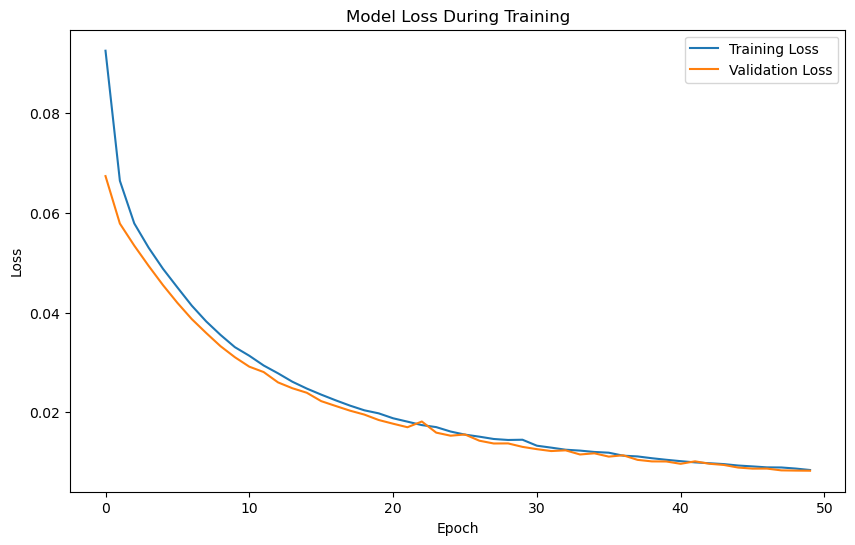

In [16]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Re-train the best model on the combined training + validation set and evaluate on the separate test set
best_model.fit(X_train_final, y_train_final, batch_size=batch_size, epochs=epoch, verbose=1)

Epoch 1/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0083
Epoch 2/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0080
Epoch 3/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0079
Epoch 4/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0077
Epoch 5/50
15/15 [==============================] - 0s 21ms/step - loss: 0.0075
Epoch 6/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0074
Epoch 7/50
15/15 [==============================] - 0s 22ms/step - loss: 0.0072
Epoch 8/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0072
Epoch 9/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0070
Epoch 10/50
15/15 [==============================] - 0s 21ms/step - loss: 0.0069
Epoch 11/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0067
Epoch 12/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0065
Epoch 13/50
15/15 [==================

1/1 [==============================] - 1s 1s/step


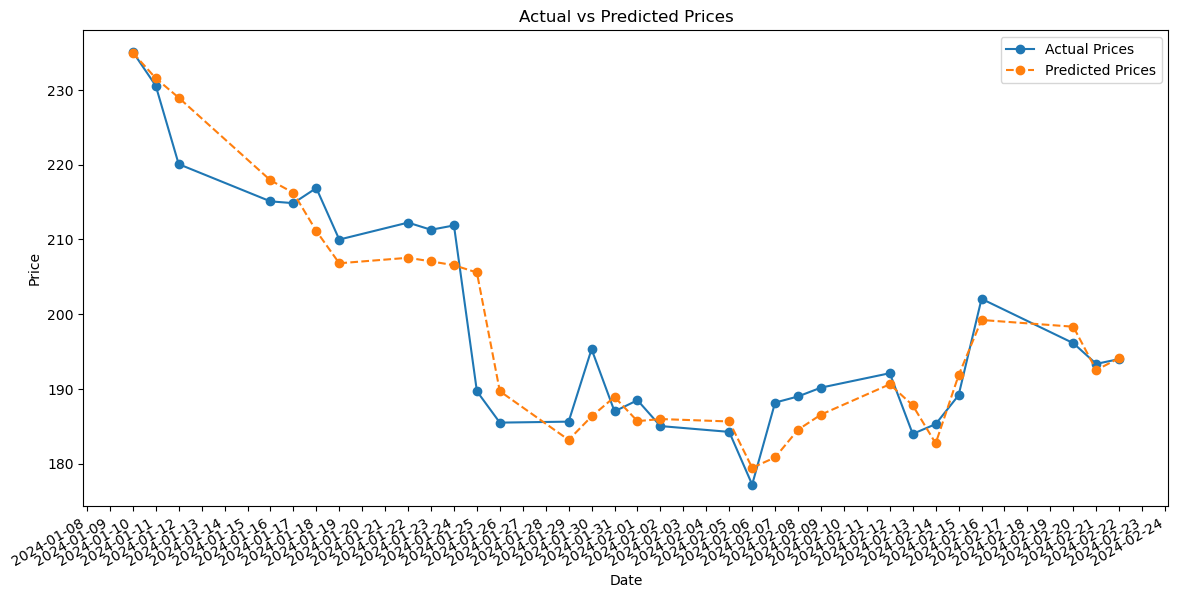

Mean Squared Error (MSE): 23.617170189716852
Mean Absolute Error (MAE): 3.6729771931966146
Root Mean Squared Error (RMSE): 4.859750013088827
R-squared (R2): 0.8944664312425705
Mean Absolute Percentage Error (MAPE): 0.01860455231210684


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.dates as mdates 

features = data.columns.tolist()

# Plot predictions
def plot_predictions(model, X, y, dates, scaler, title='Actual vs Predicted Prices'):
    predictions = model.predict(X)
    
    predictions = scaler.inverse_transform(
        np.pad(predictions, [(0, 0), (0, len(features) - 1)], 'constant'))[:, 0]
    actual = scaler.inverse_transform(
        np.pad(y.reshape(-1, 1), [(0, 0), (0, len(features) - 1)], 'constant'))[:, 0]
    
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', marker='o')
    plt.plot(dates, predictions, label='Predicted Prices', linestyle='--', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    # Format the x-axis to display dates clearly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gcf().autofmt_xdate()  # Rotation
    
    plt.show()

    # Calculate evaluation metrics
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predictions)
    mape = mean_absolute_percentage_error(actual, predictions)

    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    print("Mean Absolute Percentage Error (MAPE):", mape)


test_dates = data.index[-len(X_test_final):]
plot_predictions(best_model, X_test_final, y_test_final, test_dates, scaler)

### Mean Squared Error (MSE) and Mean Absolute Error (MAE):
- These metrics measure the average error between the predicted and actual values.
- Lower values indicate better performance.
- However, the absolute scale of these metrics is dependent on the scale of your target variable. Therefore, it's difficult to define a universally "good" threshold. It's more informative to compare these metrics across different models or variations of your LSTM model.

### Root Mean Squared Error (RMSE):
- RMSE is in the same units as the target variable, which can make it more interpretable.
- Similar to MSE and MAE, lower values are desirable.
- Like MSE and MAE, it's more useful for comparing models rather than establishing absolute thresholds.

### R-squared (R2):
- R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
- R2 ranges from 0 to 1, with higher values indicating better fit.
- A value of 1 indicates that the model explains all the variability of the response data around its mean. However, a high R2 value doesn't necessarily mean a good model, as it may overfit.
- Generally, R2 values closer to 1 are desirable, but the interpretation depends on the context and the complexity of the model.

### Mean Absolute Percentage Error (MAPE):
- MAPE measures the average absolute percentage difference between predicted and actual values.
- Lower values indicate better performance.
- A MAPE of 0% indicates a perfect fit, but in practice, it's rare to achieve such a value.
- It's common to interpret MAPE in the context of the variability of the target variable. For example, a MAPE below 10% might be considered good in some domains.

In [19]:
import datetime

def weekdays_left_in_week():
    # Get the current date
    today = datetime.date.today()

    # If today is Saturday or Sunday, return 0 since there are no weekdays left
    if today.weekday() >= 5:
        return 1

    # Calculate the number of days left in the week
    days_left = 5 - today.weekday() - 1  # Subtract 1 to exclude the current day

    return days_left


# Example usage
print("Weekdays left in the week:", weekdays_left_in_week())

Weekdays left in the week: 1


In [20]:
# Predicting Future Prices for the Next 5 Days
future_days = weekdays_left_in_week()
# Starting point for future predictionsv
last_sequence = scaled_data[-sequence_length:]
future_predictions = []

for _ in range(future_days):
    # Reshape the last sequence for prediction
    last_sequence_reshaped = last_sequence.reshape(
        (1, sequence_length, scaled_data.shape[1]))

    next_price = best_model.predict(last_sequence_reshaped)[
        0, 0]   # Predict the next price
    future_predictions.append(next_price)

    # Update the last sequence with the predicted value
    new_row = np.zeros(scaled_data.shape[1])
    new_row[0] = next_price  # Update the sequence with the predicted price
    last_sequence = np.vstack([last_sequence[1:], new_row])  # Slide the window

future_prices = scaler.inverse_transform(np.pad(np.array(
    future_predictions).reshape(-1, 1), [(0, 0), (0, scaled_data.shape[1] - 1)], 'constant'))[:, 0]

1/1 [==============================] - 0s 23ms/step


In [21]:
future_prices

array([196.64464], dtype=float32)

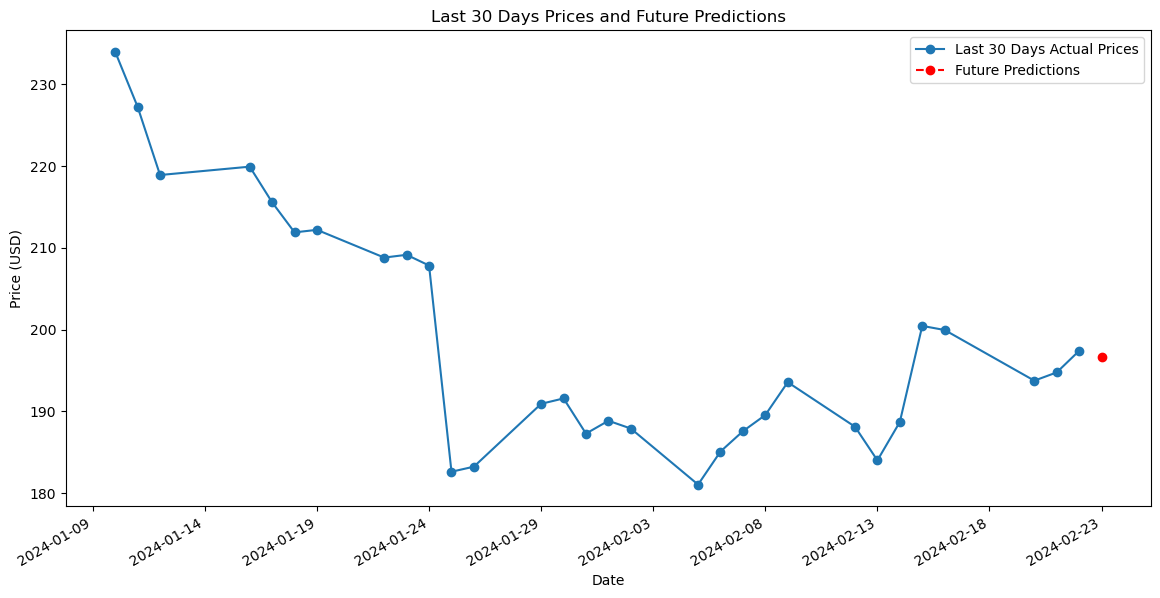

In [22]:
# Import necessary libraries
import matplotlib.dates as mdates

# Step 1: Select the last 30 days of actual price data
last_30_days = data['Close'][-30:]

# Step 2: Generate dates for the last 30 days and future predictions
last_30_dates = last_30_days.index
future_dates = pd.date_range(start=last_30_dates[-1] + pd.Timedelta(days=1), periods=future_days)

# Step 3: Plot the last 30 days of actual prices and the future predictions
plt.figure(figsize=(14, 7))

# Plot the last 30 days of actual prices
plt.plot(last_30_dates, last_30_days, label='Last 30 Days Actual Prices', marker='o', linestyle='-')

# Plot the future predictions
plt.plot(future_dates, future_prices, label='Future Predictions', marker='o', linestyle='--', color='red')

# Formatting the plot
plt.title('Last 30 Days Prices and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)

# Improve date formatting and layout
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gcf().autofmt_xdate()  # Rotation

plt.show()